In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Dense, Add, Dropout, Flatten, LayerNormalization,
    MultiHeadAttention, RandomRotation, RandomFlip
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import confusion_matrix
from functools import partial
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.18.0


In [70]:
learning_rate = 0.0001
vit_class_name=['glioma','meningioma','notumor','pituitary']
weight_decay = 0.0001
num_classes=4
batch_size =32
num_epochs = 80
image_size = 256  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
Num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
num_layers = 15
Hidden_size=64
mlp_head_units = 1024


In [16]:
vit_train_data = '/kaggle/input/brain-tumor-mri-dataset/Training'
vit_test_data = '/kaggle/input/brain-tumor-mri-dataset/Testing'


In [17]:
vit_train_dataset = tf.keras.utils.image_dataset_from_directory(
    vit_train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=vit_class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset='training',
)
vit_val_dataset = tf.keras.utils.image_dataset_from_directory(
    vit_train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=vit_class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='validation',
)
vit_test_dataset = tf.keras.utils.image_dataset_from_directory(
    vit_test_data,
    labels='inferred',
    label_mode='categorical',
    class_names=vit_class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


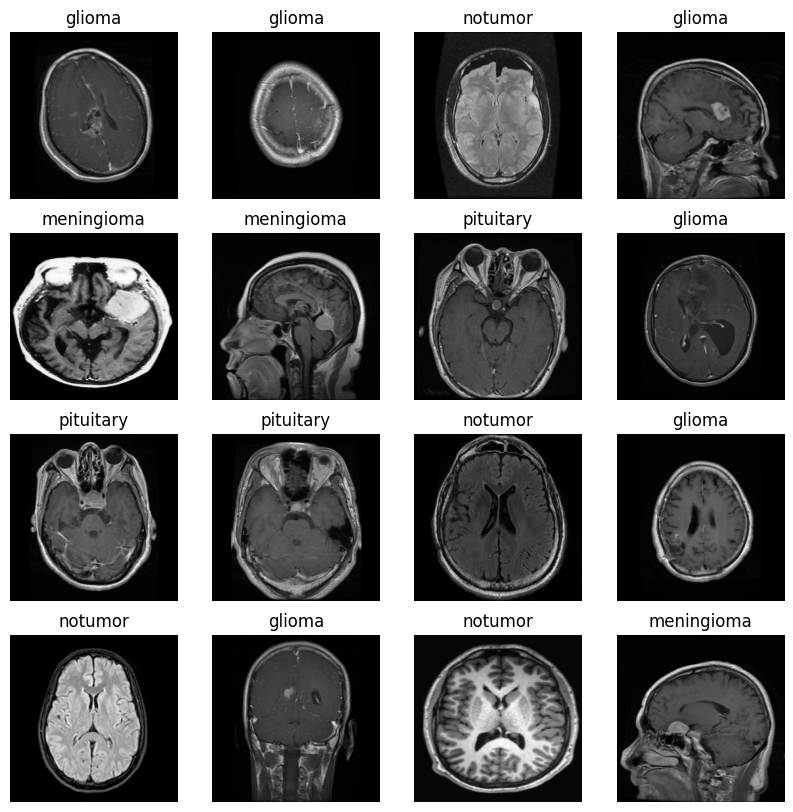

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in vit_train_dataset.take(10):
    for i in range(min(16, len(images))):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255., cmap='gray')
        plt.title(vit_class_name[tf.argmax(labels[i]).numpy()])
        plt.axis("off")

plt.show()


In [19]:
vit_augment_layers = tf.keras.Sequential([
    layers.RandomRotation(factor=0.25),
    layers.RandomFlip("horizontal_and_vertical"),
])


In [20]:
# Define a custom preprocessing function
def vit_process_data(image, label):
    augmented_image=vit_augment_layers(image)
    resized_image = tf.image.resize(augmented_image, size=(image_size, image_size))
    return resized_image, label

# Apply augmentation and preprocessing to the dataset
vit_training_dataset = (
    vit_train_dataset.
    shuffle(1000)
    .map(partial(vit_process_data),num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [21]:
vit_vali_dataset=(
   vit_val_dataset.shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)
)


In [22]:
vit_input_tensor = next(iter(vit_training_dataset))[0]


In [23]:
vit_patche=tf.image.extract_patches(images=vit_input_tensor,
                               sizes=[1,patch_size,patch_size,1],
                                strides=[1,patch_size,patch_size,1],
                                rates=[1,1,1,1],
                                 padding='VALID')


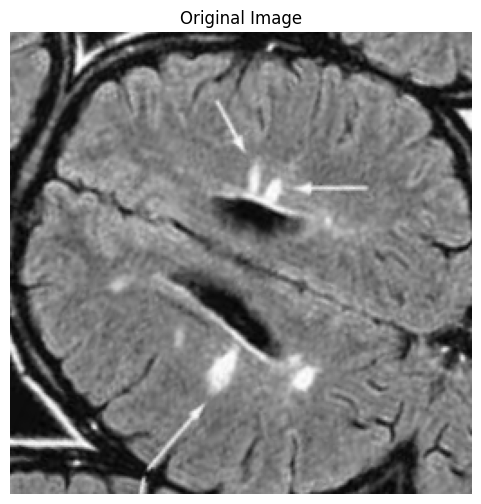

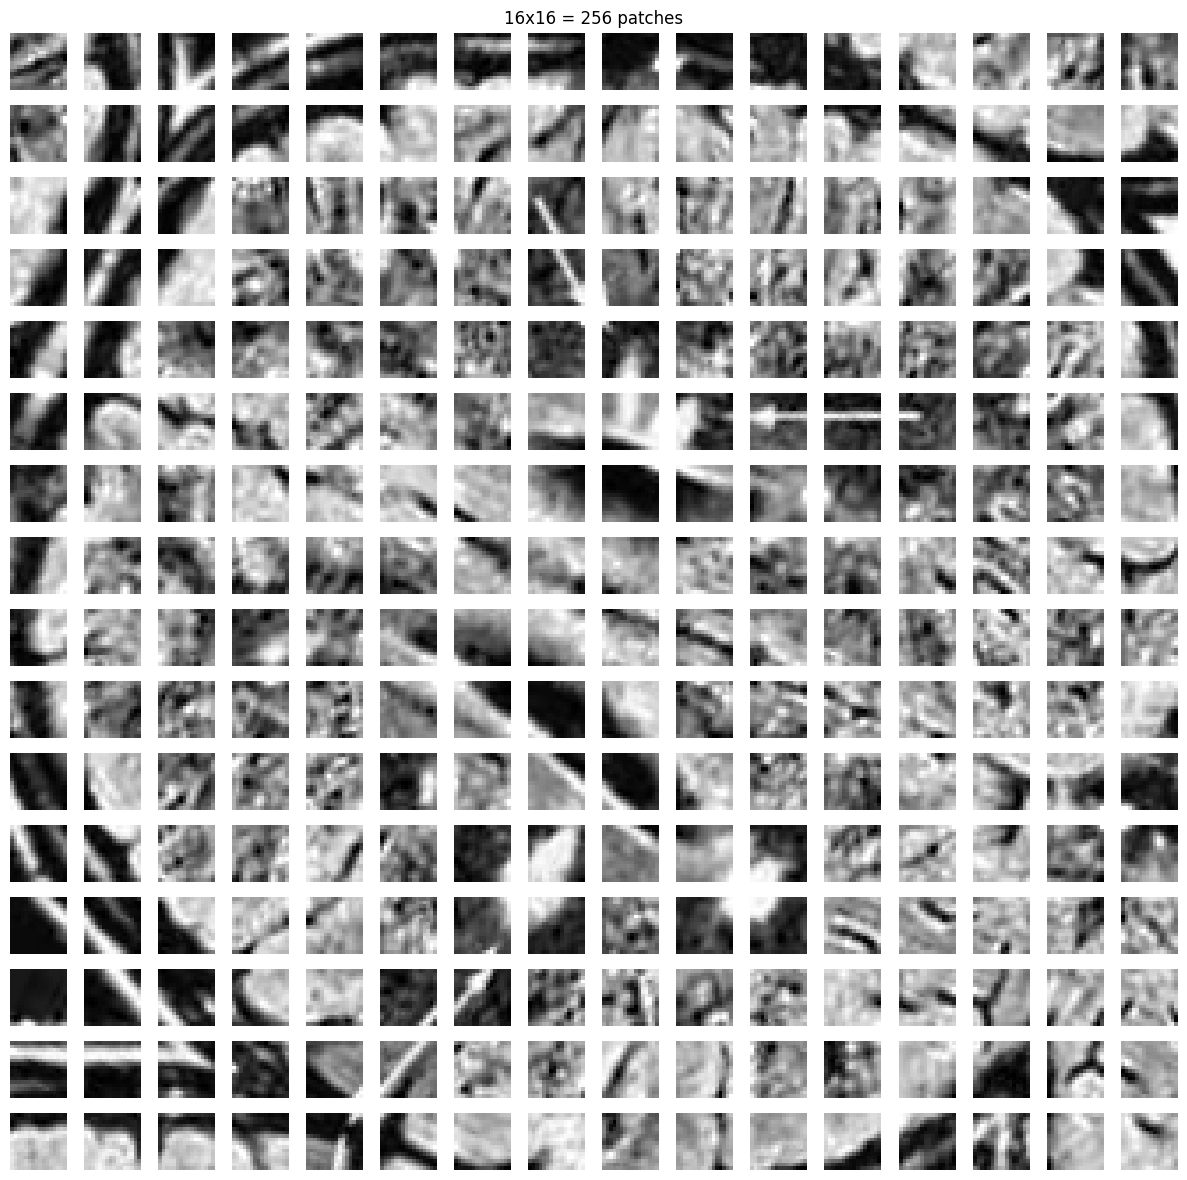

In [24]:
# Visualize patches
pic = vit_input_tensor[0].numpy().squeeze()
pic = (pic - pic.min()) / (pic.max() - pic.min() + 1e-8)  # Normalize

_, patch_rows, patch_cols, _ = vit_patche.shape

# Show original image
plt.figure(figsize=(6, 6))
plt.imshow(pic, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Show patches grid
plt.figure(figsize=(12, 12))
for i in range(patch_rows):
    for j in range(patch_cols):
        ax = plt.subplot(patch_rows, patch_cols, i * patch_cols + j + 1)
        patch = vit_patche[0, i, j, :].numpy().reshape(patch_size, patch_size)
        plt.imshow(patch, cmap='gray')
        plt.axis("off")
plt.suptitle(f'{patch_rows}x{patch_cols} = {num_patches} patches')
plt.tight_layout()
plt.show()


In [25]:
class PatchEncoder(layers.Layer):
    def __init__(self):
        super().__init__()
        self.projection = Dense(Hidden_size)
        self.position_embed = layers.Embedding(num_patches, Hidden_size)

    def call(self, images):
        batch = tf.shape(images)[0]
        # Extract patches
        patches = tf.image.extract_patches(
            images, sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1], padding='VALID'
        )
        patches = tf.reshape(patches, [batch, -1, patches.shape[-1]])
        # Project + add position embeddings
        positions = tf.range(num_patches)
        return self.projection(patches) + self.position_embed(positions)


In [26]:
class TransformerEncoder(layers.Layer):
    def __init__(self):
        super().__init__()
        self.norm1 = LayerNormalization()
        self.norm2 = LayerNormalization()
        self.attn = MultiHeadAttention(Num_heads, Hidden_size)
        self.mlp = tf.keras.Sequential([
            Dense(Hidden_size * 2, activation='gelu'),
            Dense(Hidden_size)
        ])

    def call(self, x, return_attention=False):
        # Self-attention with residual
        normed = self.norm1(x)
        if return_attention:
            attn_out, attn_weights = self.attn(normed, normed, return_attention_scores=True)
        else:
            attn_out = self.attn(normed, normed)
        x = x + attn_out

        # MLP with residual
        x = x + self.mlp(self.norm2(x))

        return (x, attn_weights) if return_attention else x


In [27]:
class VIT(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.patch_encoder = PatchEncoder()
        self.encoders = [TransformerEncoder() for _ in range(num_layers)]
        self.head = tf.keras.Sequential([
            layers.Flatten(),
            Dense(mlp_head_units, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

    def call(self, x):
        x = self.patch_encoder(x)
        for encoder in self.encoders:
            x = encoder(x)
        return self.head(x)

    def get_attention_rollout(self, x):
        """Improved Attention Rollout with layer weighting for better tumor localization"""
        x = self.patch_encoder(x)
        attentions = []
        
        for encoder in self.encoders:
            x, attn = encoder(x, return_attention=True)
            # Average across heads: (batch, num_patches, num_patches)
            attn = tf.reduce_mean(attn, axis=1)
            attentions.append(attn)

        # Weighted attention rollout - later layers weighted more (more class-specific)
        n_layers = len(attentions)
        rollout = None
        
        for i, attn in enumerate(attentions):
            # Exponential layer weighting - later layers more important
            layer_weight = np.exp((i - n_layers + 1) / 3.0)
            
            # Smaller residual for better discrimination (0.2 instead of 0.5)
            attn_with_residual = 0.8 * attn + 0.2 * tf.eye(attn.shape[-1])
            
            if rollout is None:
                rollout = attn_with_residual * layer_weight
            else:
                rollout = tf.matmul(attn_with_residual, rollout) * layer_weight

        # Use mean attention per patch (better than sum for localization)
        mask = tf.reduce_mean(rollout, axis=1)
        
        grid_size = image_size // patch_size
        mask = tf.reshape(mask, (-1, grid_size, grid_size))
        
        # Robust normalization using percentiles to handle outliers
        mask_np = mask.numpy()
        p_low = np.percentile(mask_np, 2)
        p_high = np.percentile(mask_np, 98)
        mask_np = np.clip(mask_np, p_low, p_high)
        mask_np = (mask_np - p_low) / (p_high - p_low + 1e-8)
        
        return mask_np

# Create model
vit = VIT()


In [28]:
loss_funcion=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
)


In [29]:
vit_metrics=[CategoricalAccuracy(name= 'accuracy'),TopKCategoricalAccuracy(k=2,name='top_k_accuracy')]


In [30]:
vit.compile(
    optimizer=Adam(learning_rate=learning_rate),
                   loss=loss_funcion,
                   metrics=vit_metrics
)


In [31]:
vit_checkpoint_filepath = "/content/checkpoints/vit_best.weights.h5"
vit_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    vit_checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)


In [71]:
# Train the model
vit_history = vit.fit(
    vit_training_dataset,
    epochs=num_epochs,
    verbose=1,
    validation_data=vit_vali_dataset,
    callbacks=[vit_checkpoint_callback]
)


Epoch 1/80
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.8557 - loss: 0.3752 - top_k_accuracy: 0.9807 - val_accuracy: 0.8503 - val_loss: 0.4330 - val_top_k_accuracy: 0.9694
Epoch 2/80
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.8543 - loss: 0.3705 - top_k_accuracy: 0.9771 - val_accuracy: 0.8590 - val_loss: 0.4051 - val_top_k_accuracy: 0.9737
Epoch 3/80
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.8590 - loss: 0.3619 - top_k_accuracy: 0.9764 - val_accuracy: 0.8538 - val_loss: 0.4495 - val_top_k_accuracy: 0.9667
Epoch 4/80
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.8538 - loss: 0.3657 - top_k_accuracy: 0.9763 - val_accuracy: 0.8669 - val_loss: 0.4372 - val_top_k_accuracy: 0.9711
Epoch 5/80
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.8640 - loss: 0.3639 - top_k_accuracy: 0.9835 - val_accuracy: 0.8310 - val_loss: 0.4826 - val_top_k_accuracy: 0.9632
Epoch 6/80
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.8683 -

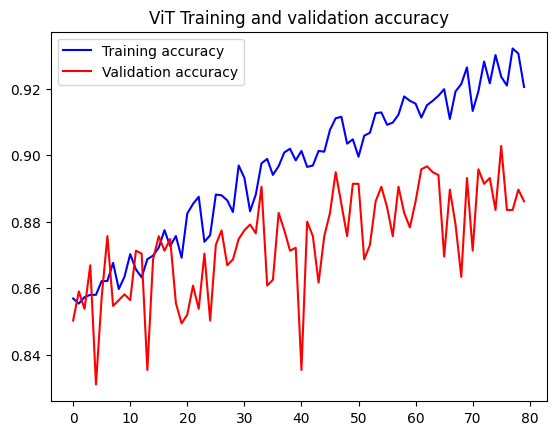

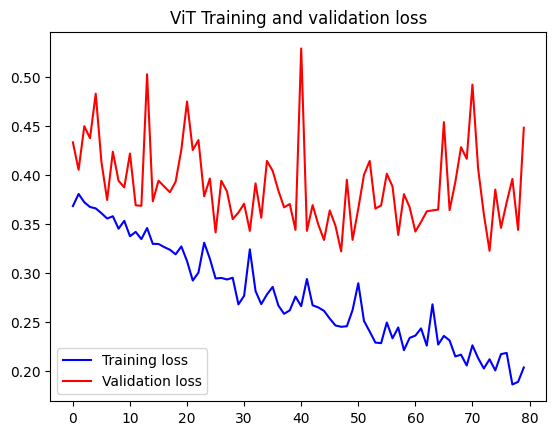

In [73]:
vit_accuracy = vit_history.history['accuracy']
vit_val_accuracy = vit_history.history['val_accuracy']

vit_loss = vit_history.history['loss']
vit_val_loss = vit_history.history['val_loss']

epochs = range(len(vit_accuracy))
plt.plot(epochs, vit_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, vit_val_accuracy, 'r', label='Validation accuracy')

plt.title('ViT Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, vit_loss, 'b', label='Training loss')
plt.plot(epochs, vit_val_loss, 'r', label='Validation loss')

plt.title('ViT Training and validation loss')
plt.legend()
plt.show()


In [74]:
vit.save('/kaggle/working//Checkpointsvit_model.keras')

In [75]:
vit.save_weights('/kaggle/working/vit_weights.weights.h5')

In [76]:
vit_pred = vit.predict(vit_test_dataset)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


In [77]:
vit.evaluate(vit_test_dataset)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8453 - loss: 0.4610 - top_k_accuracy: 0.9754


[0.5031863451004028, 0.8421052694320679, 0.9786422848701477]

In [41]:
vit_predicted=[]
vit_labels=[]
for im, label in vit_test_dataset:
    vit_predicted.append(vit(im))
    vit_labels.append(label.numpy())


In [79]:
vit_pred_arr= np.concatenate([np.argmax(vit_predicted[:-1],axis=-1).flatten(),np.argmax(vit_predicted[-1],axis=-1).flatten()])
vit_lab= np.concatenate([np.argmax(vit_labels[:-1],axis=-1).flatten(),np.argmax(vit_labels[-1],axis=-1).flatten()])


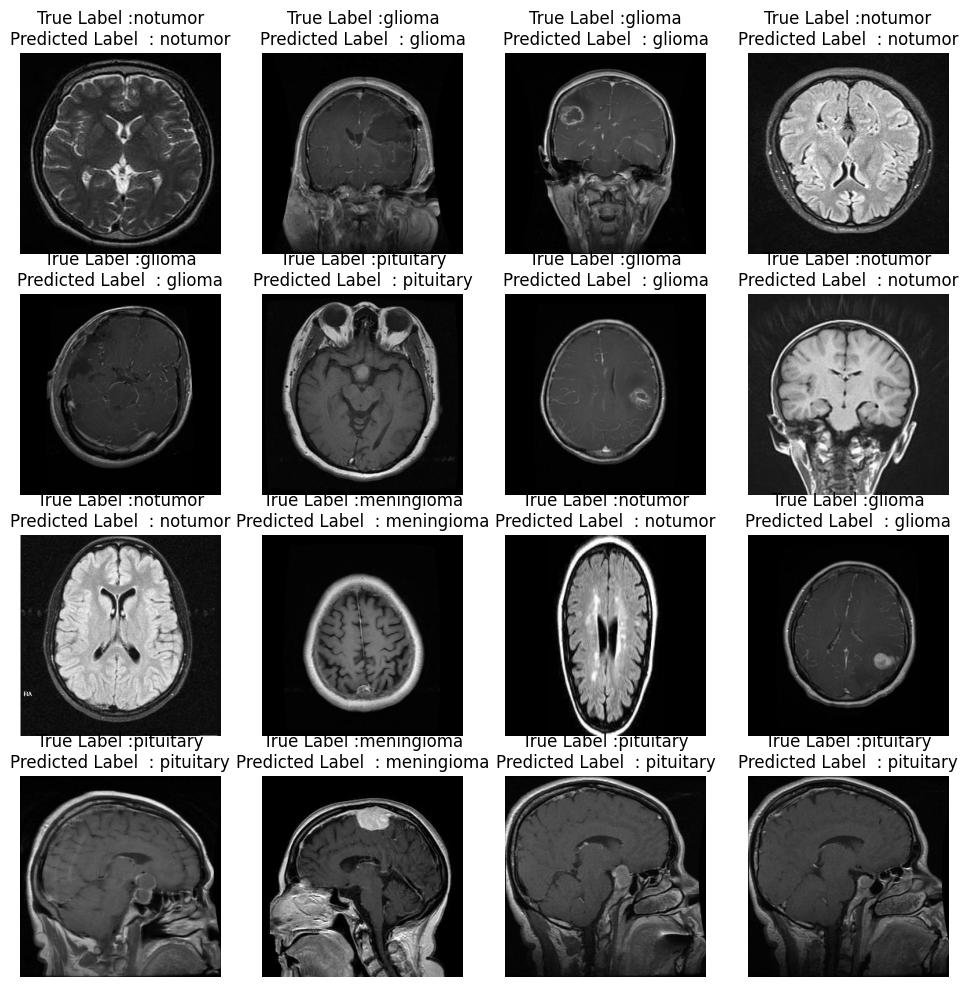

In [80]:
plt.figure(figsize=(12,12))
for images,labels in vit_test_dataset.take(10):
  for i in range(16):
   ax=plt.subplot(4,4,i+1)

   plt.imshow(images[i]/255., cmap='gray')
   plt.title("True Label :"+ vit_class_name[tf.argmax(labels[i],axis=0).numpy()] + "\n" + "Predicted Label  : " + vit_class_name[tf.argmax(vit(tf.expand_dims(images[i],axis=0)),axis= -1).numpy()[0]])
   plt.axis("off")


[[195  84   6  15]
 [ 15 187  78  26]
 [  1  13 386   5]
 [  0  31   5 264]]


Text(0.5, 58.7222222222222, 'Predicted')

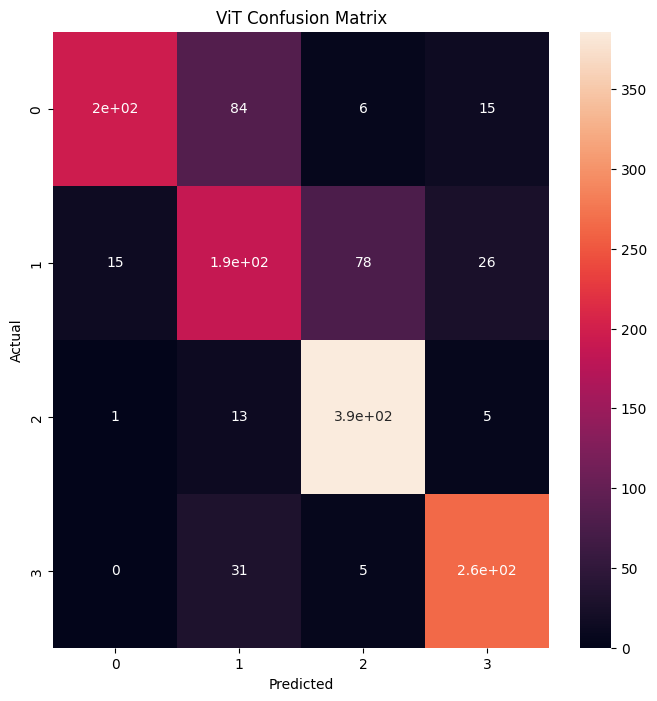

In [81]:
vit_cm=confusion_matrix(vit_lab,vit_pred_arr)
print(vit_cm)
plt.figure(figsize=(8,8))
sns.heatmap(vit_cm,annot=True)
plt.title("ViT Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel("Predicted")


In [47]:
def vit_get_kmeans_mask(image, k=3):
    """K-Means clustering for edge segmentation"""
    img = np.stack([image.squeeze()]*3, axis=-1) if image.ndim < 3 or image.shape[-1] == 1 else image
    pixels = np.float32(img.reshape(-1, 3))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, _ = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    return labels.reshape(image.shape[:2])


def extract_brain_mask(image):
    """Extract brain region, excluding skull and background"""
    img = image.squeeze()
    if img.max() > 1:
        img = img.astype(np.uint8)
    else:
        img = (img * 255).astype(np.uint8)
    
    # Threshold to get foreground (brain + skull)
    _, binary = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)
    
    # Flood fill from corners to remove external background
    h, w = binary.shape
    mask = np.zeros((h + 2, w + 2), np.uint8)
    flood = binary.copy()
    
    # Flood fill from all four corners
    for seed in [(0, 0), (0, w-1), (h-1, 0), (h-1, w-1)]:
        cv2.floodFill(flood, mask.copy(), seed, 0)
    
    brain_region = flood
    
    # Morphological operations to clean up
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    brain_region = cv2.morphologyEx(brain_region, cv2.MORPH_CLOSE, kernel, iterations=2)
    brain_region = cv2.morphologyEx(brain_region, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Erode slightly to remove skull edge
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    brain_region = cv2.erode(brain_region, kernel_small, iterations=2)
    
    return brain_region > 0


def adaptive_attention_threshold(attention_map, brain_mask=None):
    """Compute adaptive threshold based on attention distribution within brain"""
    if brain_mask is not None:
        attn_in_brain = attention_map[brain_mask]
    else:
        attn_in_brain = attention_map.flatten()
    
    if len(attn_in_brain) == 0:
        return np.percentile(attention_map, 75)
    
    # Use Otsu's method on attention values
    attn_normalized = ((attn_in_brain - attn_in_brain.min()) / 
                       (attn_in_brain.max() - attn_in_brain.min() + 1e-8) * 255).astype(np.uint8)
    
    thresh_val, _ = cv2.threshold(attn_normalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Convert back to original scale
    threshold = attn_in_brain.min() + (thresh_val / 255.0) * (attn_in_brain.max() - attn_in_brain.min())
    
    # Ensure threshold is reasonable (between 50th and 85th percentile)
    p50 = np.percentile(attn_in_brain, 50)
    p85 = np.percentile(attn_in_brain, 85)
    threshold = np.clip(threshold, p50, p85)
    
    return threshold


def find_tumor_cluster(km_labels, attention_map, display_img, brain_mask, k=4):
    """Find the cluster most likely to be the tumor based on multiple criteria"""
    best_cluster = None
    best_score = -np.inf
    
    for c in range(k):
        cluster = km_labels == c
        cluster_in_brain = cluster & brain_mask if brain_mask is not None else cluster
        
        cluster_size = np.sum(cluster_in_brain)
        
        # Skip very small or very large clusters
        total_brain = np.sum(brain_mask) if brain_mask is not None else image_size * image_size
        if cluster_size < 100 or cluster_size > total_brain * 0.6:
            continue
        
        # Multiple scoring criteria for tumor detection:
        # 1. High attention overlap (most important)
        attn_score = np.mean(attention_map[cluster_in_brain]) if cluster_size > 0 else 0
        
        # 2. Intensity variance (tumors often have heterogeneous texture)
        intensity_var = np.std(display_img[cluster_in_brain]) if cluster_size > 0 else 0
        
        # 3. Compactness (tumors are typically compact regions)
        contours, _ = cv2.findContours(cluster_in_brain.astype(np.uint8), 
                                        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            perimeter = cv2.arcLength(largest_contour, True)
            area = cv2.contourArea(largest_contour)
            compactness = (4 * np.pi * area) / (perimeter ** 2 + 1e-8) if perimeter > 0 else 0
        else:
            compactness = 0
        
        # 4. Centrality (tumors often in interior, not at edges)
        y_coords, x_coords = np.where(cluster_in_brain)
        if len(x_coords) > 0:
            center_y, center_x = image_size // 2, image_size // 2
            dist_from_center = np.sqrt((np.mean(x_coords) - center_x)**2 + 
                                       (np.mean(y_coords) - center_y)**2)
            centrality = 1 - (dist_from_center / (image_size * 0.5))
        else:
            centrality = 0
        
        # Combined score (attention is weighted highest)
        score = (attn_score * 3.0 + 
                 (intensity_var / 50) * 0.5 + 
                 compactness * 1.0 + 
                 centrality * 0.5)
        
        if score > best_score:
            best_score = score
            best_cluster = cluster_in_brain
    
    return best_cluster


def vit_clean_mask(mask, image):
    """Clean segmentation mask using morphology"""
    mask_u8 = (mask * 255).astype(np.uint8)
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(mask_u8, cv2.MORPH_CLOSE, kernel, iterations=3)

    gray = image.squeeze().astype(np.uint8) if image.ndim == 3 else image.astype(np.uint8)
    _, dark = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY_INV)

    # Flood fill from corner to remove background
    flood = dark.copy()
    cv2.floodFill(flood, np.zeros((gray.shape[0]+2, gray.shape[1]+2), np.uint8), (0,0), 0)
    combined = cv2.bitwise_or(closed, flood)

    # Keep largest connected component
    n, labels, stats, _ = cv2.connectedComponentsWithStats(combined)
    if n > 1:
        largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        return labels == largest
    return mask > 0

print("Improved segmentation functions loaded!")


Improved segmentation functions loaded!


Sample: meningioma


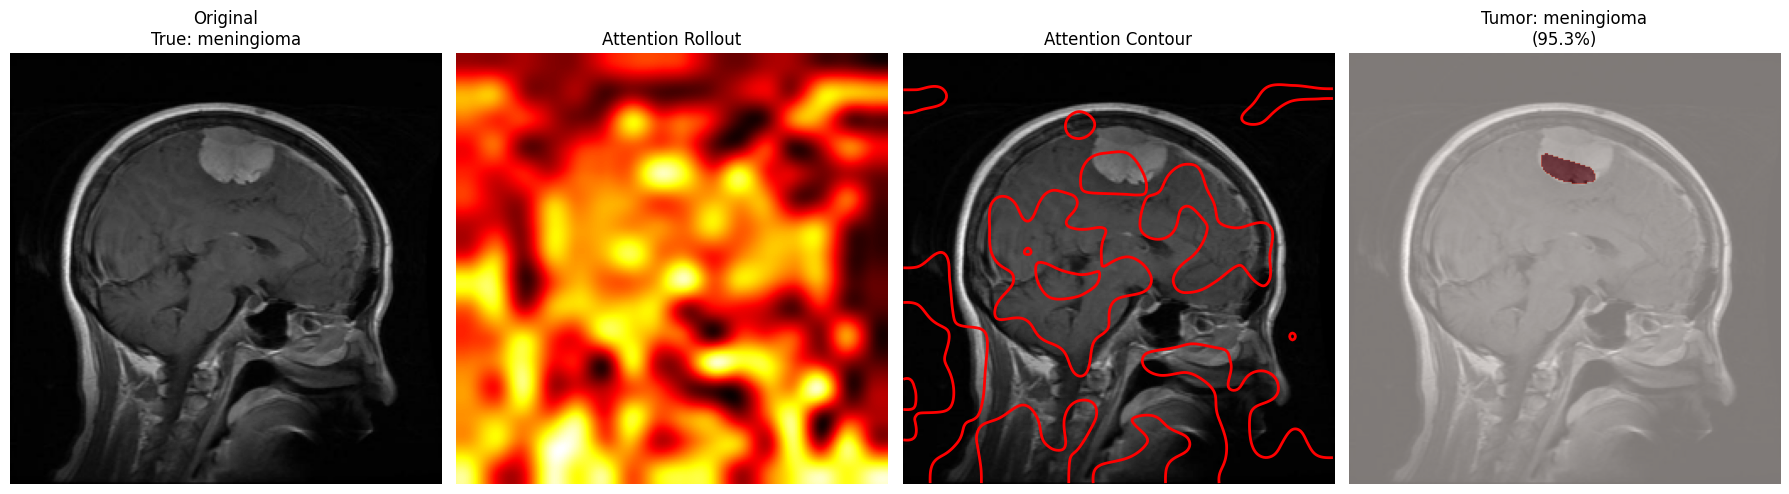

In [ ]:
def segment_tumor(model, img):
    img_batch = img[np.newaxis, ...]

    # Get prediction
    pred = model.predict(img_batch, verbose=0)
    pred_idx = np.argmax(pred)
    pred_label = vit_class_name[pred_idx]
    confidence = np.max(pred) * 100

    # Normalize display image
    display = (img.squeeze() * 255 / (img.max() + 1e-8)).astype(np.uint8)

    # Get improved attention rollout
    attn = model.get_attention_rollout(img_batch)[0]
    attn = cv2.resize(attn, (image_size, image_size), interpolation=cv2.INTER_CUBIC)

    # If NO TUMOR predicted, return empty segmentation
    if pred_label == 'notumor':
        empty_mask = np.zeros((image_size, image_size), dtype=bool)
        return attn, empty_mask, display, pred_label, confidence
    
    # Step 1: Extract brain mask (exclude skull and background)
    brain_mask = extract_brain_mask(display)
    
    # Step 2: Use adaptive threshold based on attention distribution within brain
    attn_threshold = adaptive_attention_threshold(attn, brain_mask)
    attn_mask = (attn > attn_threshold) & brain_mask
    
    # Step 3: K-Means clustering within brain region
    km_labels = vit_get_kmeans_mask(display, k=4)
    
    # Step 4: Find best tumor cluster using multi-criteria scoring
    best_cluster = find_tumor_cluster(km_labels, attn, display, brain_mask, k=4)
    
    if best_cluster is None:
        # Fallback to attention-only segmentation
        best_cluster = attn_mask
    
    # Step 5: Combine attention mask with best cluster
    # Use intersection to be more precise
    combined = attn_mask & best_cluster
    
    # If intersection is too small, use union with more weight on attention
    if np.sum(combined) < 100:
        combined = attn_mask | (best_cluster & (attn > np.percentile(attn[brain_mask], 60)))
    
    # Ensure we stay within brain mask
    combined = combined & brain_mask
    
    # Step 6: Morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    combined_u8 = combined.astype(np.uint8) * 255
    combined_u8 = cv2.morphologyEx(combined_u8, cv2.MORPH_CLOSE, kernel, iterations=2)
    combined_u8 = cv2.morphologyEx(combined_u8, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Step 7: Keep only the largest connected component
    n, labels_map, stats, centroids = cv2.connectedComponentsWithStats(combined_u8)
    if n > 1:
        # Filter out very small components
        valid_components = []
        for i in range(1, n):
            area = stats[i, cv2.CC_STAT_AREA]
            if area > 50:  # Minimum area threshold
                # Score by area and attention overlap
                comp_mask = labels_map == i
                attn_in_comp = np.mean(attn[comp_mask])
                valid_components.append((i, area * attn_in_comp))
        
        if valid_components:
            # Select component with highest score
            best_comp = max(valid_components, key=lambda x: x[1])[0]
            final_mask = (labels_map == best_comp)
        else:
            final_mask = combined_u8 > 0
    else:
        final_mask = combined_u8 > 0
    
    # Step 8: Final smoothing with convex hull approximation for cleaner edges
    if np.any(final_mask):
        contours, _ = cv2.findContours(final_mask.astype(np.uint8), 
                                        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            # Get convex hull for smoother boundary
            hull_mask = np.zeros_like(final_mask, dtype=np.uint8)
            for contour in contours:
                hull = cv2.convexHull(contour)
                cv2.drawContours(hull_mask, [hull], 0, 1, -1)
            # Blend original and hull for balance between accuracy and smoothness
            final_mask = ((final_mask.astype(np.float32) + hull_mask.astype(np.float32)) / 2) > 0.4

    return attn, final_mask, display, pred_label, confidence

# Visualize
for images, labels in vit_test_dataset.take(1):
    idx = np.random.randint(len(images))
    img = images[idx].numpy()
    true_label = vit_class_name[tf.argmax(labels[idx]).numpy()]
    print(f"Sample: {true_label}")

    attn, seg_mask, display, pred_label, conf = segment_tumor(vit, img)

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    axes[0].imshow(display, cmap='gray')
    axes[0].set_title(f"Original\nTrue: {true_label}")
    axes[1].imshow(attn, cmap='hot')
    axes[1].set_title("Attention Rollout")
    axes[2].imshow(display, cmap='gray')
    if pred_label != 'notumor':
        axes[2].contour(attn, levels=[np.percentile(attn, 70)], colors='red', linewidths=2)
    axes[2].set_title("Attention Contour" if pred_label != 'notumor' else "No Tumor Detected")
    axes[3].imshow(display, cmap='gray')
    if np.any(seg_mask):
        axes[3].imshow(seg_mask, alpha=0.5, cmap='Reds')
        axes[3].set_title(f"Tumor: {pred_label}\n({conf:.1f}%)")
    else:
        axes[3].set_title(f"No Tumor\n({conf:.1f}%)")
    for ax in axes: ax.axis('off')
    plt.tight_layout()
    plt.show()


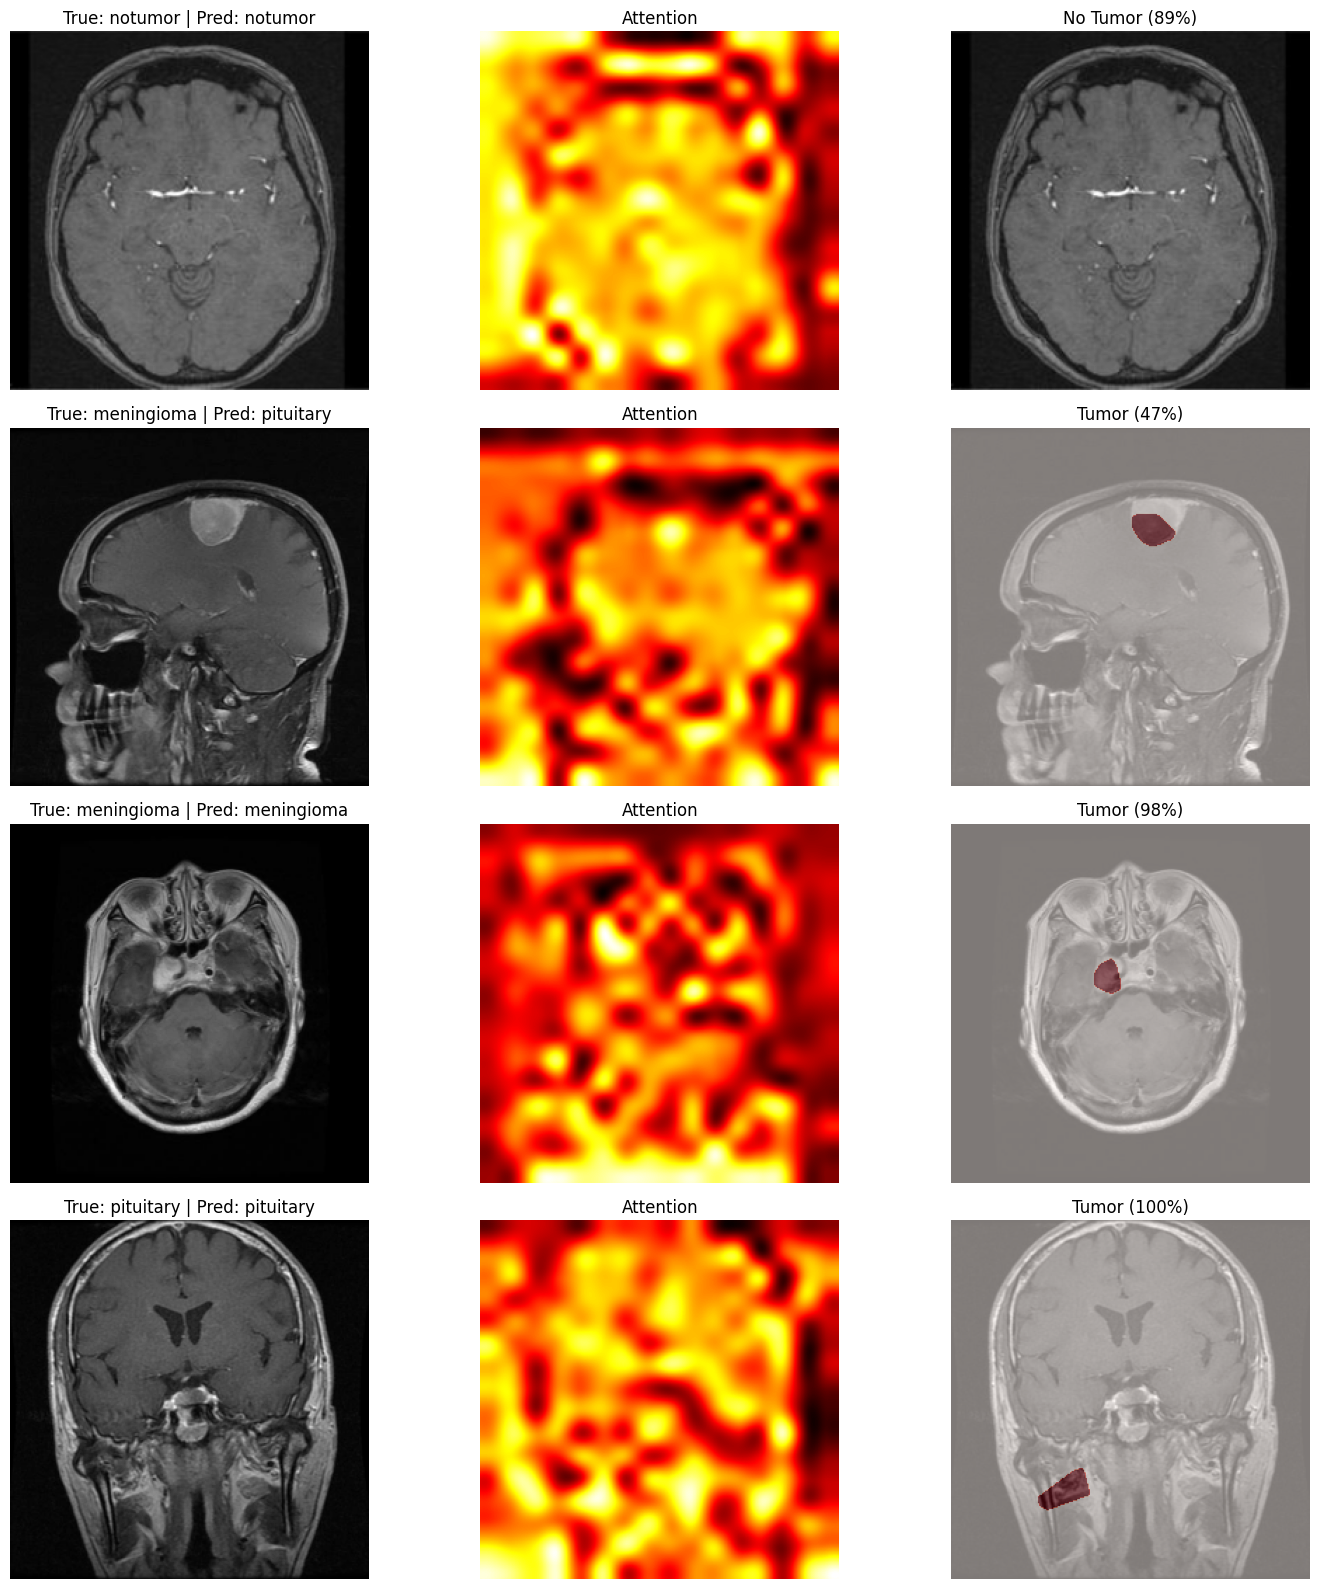

In [55]:
# Batch Segmentation (4 samples) - Skips 'notumor' cases

fig, axes = plt.subplots(4, 3, figsize=(15, 16))

for images, labels in vit_test_dataset.take(1):
    for i in range(min(4, len(images))):
        img = images[i].numpy()
        true_label = vit_class_name[tf.argmax(labels[i]).numpy()]

        # Use improved segmentation
        attn, seg_mask, display, pred_label, conf = segment_tumor(vit, img)

        # Plot row
        axes[i, 0].imshow(display, cmap='gray')
        axes[i, 0].set_title(f"True: {true_label} | Pred: {pred_label}")
        axes[i, 1].imshow(attn, cmap='hot')
        axes[i, 1].set_title("Attention")
        axes[i, 2].imshow(display, cmap='gray')
        if np.any(seg_mask):
            axes[i, 2].imshow(seg_mask, alpha=0.5, cmap='Reds')
            axes[i, 2].set_title(f"Tumor ({conf:.0f}%)")
        else:
            axes[i, 2].set_title(f"No Tumor ({conf:.0f}%)")

for ax in axes.flat: ax.axis('off')
plt.tight_layout()
plt.show()
